In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

# Define paths
data_dir = '/content/drive/My Drive/Dataset'
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True

)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 399 images belonging to 6 classes.
Found 97 images belonging to 6 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model parameters
input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)

custom_cnn = create_custom_cnn(input_shape, num_classes)
custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=resnet_base.input, outputs=predictions)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
# Training Custom CNN
history_custom_cnn = custom_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Training ResNet50
history_resnet = model_resnet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
13/13 [==============================] - 240s 18s/step - loss: 2.6024 - accuracy: 0.2607 - val_loss: 1.6309 - val_accuracy: 0.3299
Epoch 2/10
13/13 [==============================] - 107s 8s/step - loss: 1.6149 - accuracy: 0.3158 - val_loss: 1.6448 - val_accuracy: 0.3608
Epoch 3/10
13/13 [==============================] - 110s 8s/step - loss: 1.5513 - accuracy: 0.3283 - val_loss: 1.6363 - val_accuracy: 0.2990
Epoch 4/10
13/13 [==============================] - 109s 9s/step - loss: 1.4388 - accuracy: 0.3935 - val_loss: 1.5906 - val_accuracy: 0.3299
Epoch 5/10
13/13 [==============================] - 111s 8s/step - loss: 1.3954 - accuracy: 0.4286 - val_loss: 1.5907 - val_accuracy: 0.3402
Epoch 6/10
13/13 [==============================] - 108s 8s/step - loss: 1.3304 - accuracy: 0.4812 - val_loss: 1.5941 - val_accuracy: 0.3711
Epoch 7/10
13/13 [==============================] - 108s 8s/step - loss: 1.3367 - accuracy: 0.4486 - val_loss: 1.5249 - val_accuracy: 0.4433
Epoch 8/10
1

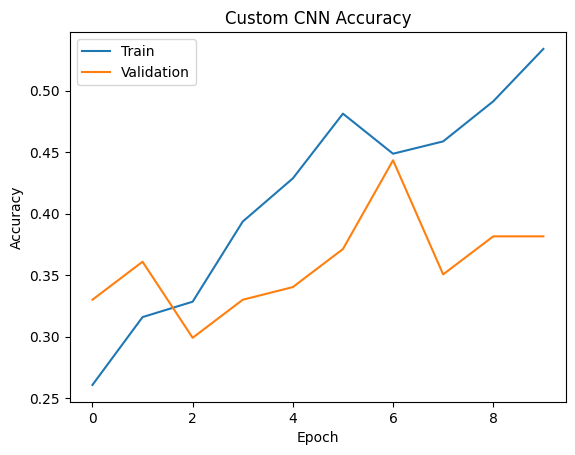

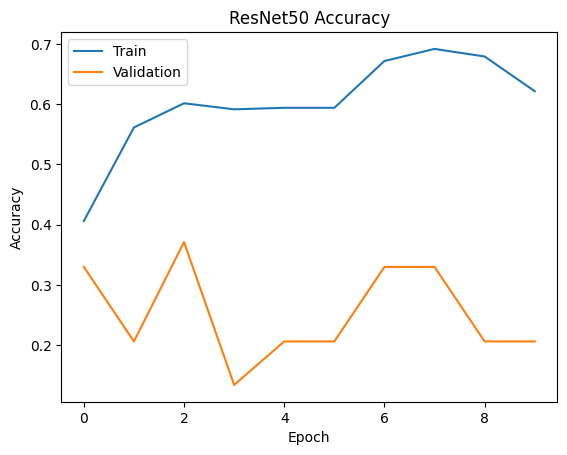

4/4 [==============================] - 26s 5s/step - loss: 3.8763 - accuracy: 0.2062


In [8]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plotting the training history
plot_history(history_custom_cnn, 'Custom CNN Accuracy')
plot_history(history_resnet, 'ResNet50 Accuracy')

# Evaluate on validation data
custom_cnn_performance = custom_cnn.evaluate(validation_generator)
resnet_performance = model_resnet.evaluate(validation_generator)

In [9]:
print("Custom CNN Accuracy: {:.2f}%".format(custom_cnn_performance[1] * 100))
print("ResNet50 Accuracy: {:.2f}%".format(resnet_performance[1] * 100))

Custom CNN Accuracy: 38.14%
ResNet50 Accuracy: 20.62%
